=== COLUMNS & SHAPE ===
['R&D_Spend', 'Administration', 'Marketing_Spend', 'Profit', 'Total_Spend', 'Growth_Spend = R&D + Marketing', 'ROI', 'State_California', 'State_Florida', 'State_New York', 'R&D_Spend_scaled', 'Administration_scaled', 'Marketing_Spend_scaled', 'Growth_Spend', 'Total_Spend_scaled', 'ROI_scaled']
Shape: (993, 16) 

Duplicates removed: 0
Rows removed due to missing Profit: 0
After cleaning shape: (993, 16) 

Features for Model A: ['R&D_Spend_scaled', 'Administration_scaled', 'Marketing_Spend_scaled', 'State_California', 'State_Florida', 'State_New York']
Features for Model B: ['R&D_Spend_scaled', 'Administration_scaled', 'Marketing_Spend_scaled'] 

XA_train: (794, 6) | XA_test: (199, 6)
XB_train: (794, 3) | XB_test: (199, 3) 

Model A (Scaled + State)
R²   : 0.9103
MAE  : 2154.21
RMSE : 13875.24

Model B (Scaled only)
R²   : 0.9106
MAE  : 2077.77
RMSE : 13851.15

=== Coefficients – Model A (with State) ===
                  Feature   Coefficient
0        R&D_Spend_s

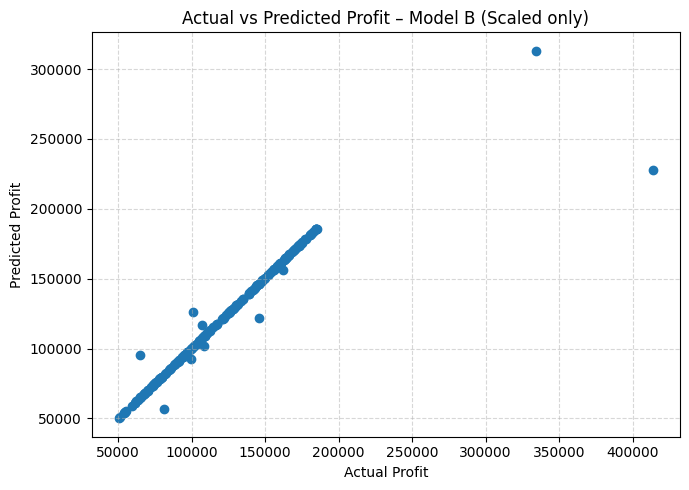

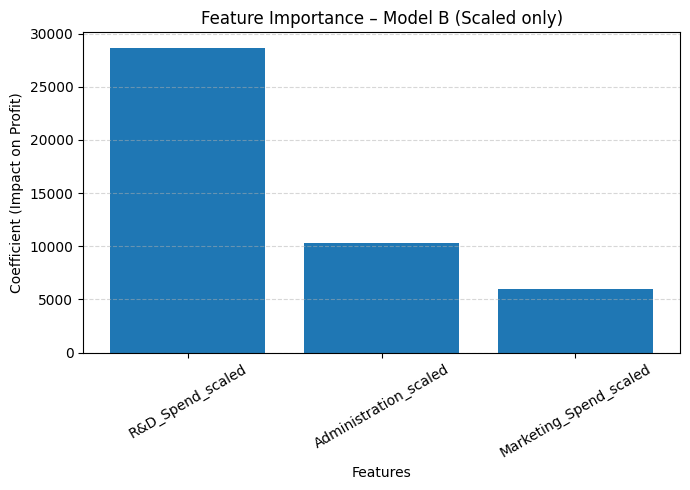

In [2]:
# ============================================
# Linear Regression – Profit Prediction (Your Dataset)
# ============================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# 1. Load dataset
# ------------------------------------------------
# CHANGE this path to where your CSV is stored locally
file_path = r"d:\DTD\Project\Dataset\Final data transfromed dataset.csv"  
df = pd.read_csv(file_path)

print("=== COLUMNS & SHAPE ===")
print(df.columns.tolist())
print("Shape:", df.shape, "\n")

# 2. Basic cleaning
# ------------------------------------------------
# Drop exact duplicate rows
before_dup = df.shape[0]
df = df.drop_duplicates()
after_dup = df.shape[0]
print(f"Duplicates removed: {before_dup - after_dup}")

# Drop rows with missing target Profit
before_na_profit = df.shape[0]
df = df.dropna(subset=["Profit"])
after_na_profit = df.shape[0]
print(f"Rows removed due to missing Profit: {before_na_profit - after_na_profit}")

# Fill any missing numeric values in RAW spend columns (if any)
num_cols_raw = ["R&D_Spend", "Administration", "Marketing_Spend"]
for col in num_cols_raw:
    if df[col].isna().sum() > 0:
        med = df[col].median()
        df[col] = df[col].fillna(med)
        print(f"Filled missing values in {col} with median {med:.2f}")

print("After cleaning shape:", df.shape, "\n")

# 3. Define features & target
# ------------------------------------------------
# Target
y = df["Profit"]

# Model A uses SCALED features + STATE one-hot columns 
features_A = [
    "R&D_Spend_scaled",
    "Administration_scaled",
    "Marketing_Spend_scaled",
    "State_California",
    "State_Florida",
    "State_New York"
]

# Model B uses ONLY scaled numerical features (no state)
features_B = [
    "R&D_Spend_scaled",
    "Administration_scaled",
    "Marketing_Spend_scaled"
]

XA = df[features_A]
XB = df[features_B]

print("Features for Model A:", features_A)
print("Features for Model B:", features_B, "\n")

# 4. Train/Test split (same random_state so it's a fair comparison)
# ------------------------------------------------
XA_train, XA_test, y_train_A, y_test_A = train_test_split(
    XA, y, test_size=0.2, random_state=42
)

XB_train, XB_test, y_train_B, y_test_B = train_test_split(
    XB, y, test_size=0.2, random_state=42
)

print("XA_train:", XA_train.shape, "| XA_test:", XA_test.shape)
print("XB_train:", XB_train.shape, "| XB_test:", XB_test.shape, "\n")

# 5. Train both Linear Regression models
# ------------------------------------------------
model_A = LinearRegression()
model_A.fit(XA_train, y_train_A)

model_B = LinearRegression()
model_B.fit(XB_train, y_train_B)

# 6. Predictions and evaluation
# ------------------------------------------------
y_pred_A = model_A.predict(XA_test)
y_pred_B = model_B.predict(XB_test)

def evaluate_model(name, y_true, y_pred):
    r2  = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))  # ← FIXED

    print(f"{name}")
    print(f"R²   : {r2:.4f}")
    print(f"MAE  : {mae:.2f}")
    print(f"RMSE : {rmse:.2f}\n")
    return r2, mae, rmse


r2_A, mae_A, rmse_A = evaluate_model("Model A (Scaled + State)", y_test_A, y_pred_A)
r2_B, mae_B, rmse_B = evaluate_model("Model B (Scaled only)",   y_test_B, y_pred_B)

# 7. Coefficients (Feature Importance)
# ------------------------------------------------
coef_A = pd.DataFrame({
    "Feature": features_A,
    "Coefficient": model_A.coef_
}).sort_values(by="Coefficient", ascending=False)

coef_B = pd.DataFrame({
    "Feature": features_B,
    "Coefficient": model_B.coef_
}).sort_values(by="Coefficient", ascending=False)

print("=== Coefficients – Model A (with State) ===")
print(coef_A, "\n")
print("=== Coefficients – Model B (no State) ===")
print(coef_B, "\n")

# 8. Visualization – Actual vs Predicted (Final chosen model: B if it's better)
# ------------------------------------------------
# Choose better model based on higher R² (if tie, use simpler one: Model B)
better_model_name = "Model B (Scaled only)" if r2_B >= r2_A else "Model A (Scaled + State)"
print(f"Better model based on R²: {better_model_name}\n")

if better_model_name == "Model B (Scaled only)":
    y_true_final = y_test_B
    y_pred_final = y_pred_B
    coef_final = coef_B
else:
    y_true_final = y_test_A
    y_pred_final = y_pred_A
    coef_final = coef_A

plt.figure(figsize=(7, 5))
plt.scatter(y_true_final, y_pred_final)
plt.xlabel("Actual Profit")
plt.ylabel("Predicted Profit")
plt.title(f"Actual vs Predicted Profit – {better_model_name}")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

# 9. Visualization – Coefficient bar plot (Final model)
# ------------------------------------------------
plt.figure(figsize=(7, 5))
plt.bar(coef_final["Feature"], coef_final["Coefficient"])
plt.xlabel("Features")
plt.ylabel("Coefficient (Impact on Profit)")
plt.title(f"Feature Importance – {better_model_name}")
plt.xticks(rotation=30)
plt.grid(True, axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


